## Hodgkin-Huxley model

This implementation of the HH model is a port of a SciPy version, taken from:
https://gribblelab.org/compneuro2012/3_Modelling_Action_Potentials.html    

Equations are from this article: O. Ekeberg, P. Wallen, A. Lansner, H. Traven, L. Brodin, and S. Grillner. A computer based model for realistic simulations of neural networks. I. The single neuron and synaptic interaction. Biol Cybern, 65(2):81--90, 1991.

In [1]:
import torch
import matplotlib.pyplot as plt

from diffeqtorch import DiffEq
%matplotlib inline

# Passive properties
E_params_E_leak = -7.0e-2
E_params_G_leak = 3.0e-09
E_params_C_m = 3.0e-11
E_params_I_ext = 1.0e-10  # Set to 0 to disable current

# Sodium channels
Na_params_Na_E = 5.0e-2
Na_params_Na_G = 1.0e-6
Na_params_k_Na_act = 3.0e+0
Na_params_A_alpha_m_act = 2.0e+5
Na_params_B_alpha_m_act = -4.0e-2
Na_params_C_alpha_m_act = 1.0e-3
Na_params_A_beta_m_act = 6.0e+4
Na_params_B_beta_m_act = -4.9e-2
Na_params_C_beta_m_act = 2.0e-2
Na_params_l_Na_inact = 1.0e+0
Na_params_A_alpha_m_inact = 8.0e+4
Na_params_B_alpha_m_inact = -4.0e-2
Na_params_C_alpha_m_inact = 1.0e-3
Na_params_A_beta_m_inact = 4.0e+2
Na_params_B_beta_m_inact = -3.6e-2
Na_params_C_beta_m_inact = 2.0e-3

# Potassium channels
K_params_k_E = -9.0e-2
K_params_k_G = 2.0e-7
K_params_k_K = 4.0e+0
K_params_A_alpha_m_act = 2.0e+4
K_params_B_alpha_m_act = -3.1e-2
K_params_C_alpha_m_act = 8.0e-4
K_params_A_beta_m_act = 5.0e+3
K_params_B_beta_m_act = -2.8e-2
K_params_C_beta_m_act = 4.0e-4

# All parameters as a list
params = [E_params_E_leak, E_params_G_leak, E_params_C_m, E_params_I_ext, Na_params_Na_E, Na_params_Na_G, Na_params_k_Na_act, Na_params_A_alpha_m_act, Na_params_B_alpha_m_act, Na_params_C_alpha_m_act, Na_params_A_beta_m_act, Na_params_B_beta_m_act, Na_params_C_beta_m_act, Na_params_l_Na_inact, Na_params_A_alpha_m_inact, Na_params_B_alpha_m_inact, Na_params_C_alpha_m_inact, Na_params_A_beta_m_inact, Na_params_B_beta_m_inact, Na_params_C_beta_m_inact, K_params_k_E, K_params_k_G, K_params_k_K, K_params_A_alpha_m_act, K_params_B_alpha_m_act, K_params_C_alpha_m_act, K_params_A_beta_m_act, K_params_B_beta_m_act, K_params_C_beta_m_act]

# ODE specified in Julia as a string, see DifferentialEquations.jl for documentation
f = """
function f(du,u,p,t)
    # Unpack state variables
    E = u[1]
    m = u[2]
    h = u[3]
    n = u[4]

    # Unpack parameters
    E_params_E_leak, E_params_G_leak, E_params_C_m, E_params_I_ext, Na_params_Na_E, Na_params_Na_G, Na_params_k_Na_act, Na_params_A_alpha_m_act, Na_params_B_alpha_m_act, Na_params_C_alpha_m_act, Na_params_A_beta_m_act, Na_params_B_beta_m_act, Na_params_C_beta_m_act, Na_params_l_Na_inact, Na_params_A_alpha_m_inact, Na_params_B_alpha_m_inact, Na_params_C_alpha_m_inact, Na_params_A_beta_m_inact, Na_params_B_beta_m_inact, Na_params_C_beta_m_inact, K_params_k_E, K_params_k_G, K_params_k_K, K_params_A_alpha_m_act, K_params_B_alpha_m_act, K_params_C_alpha_m_act, K_params_A_beta_m_act, K_params_B_beta_m_act, K_params_C_beta_m_act = p

    # external current (from "voltage clamp", other compartments, other neurons, etc)
    I_ext = E_params_I_ext

    # calculate Na rate functions and I_Na
    alpha_act = Na_params_A_alpha_m_act * (E-Na_params_B_alpha_m_act) / (1.0 - exp((Na_params_B_alpha_m_act-E) / Na_params_C_alpha_m_act))
    beta_act = Na_params_A_beta_m_act * (Na_params_B_beta_m_act-E) / (1.0 - exp((E-Na_params_B_beta_m_act) / Na_params_C_beta_m_act) )
    du[2] = ( alpha_act * (1.0 - m) ) - ( beta_act * m )

    alpha_inact = Na_params_A_alpha_m_inact * (Na_params_B_alpha_m_inact-E) / (1.0 - exp((E-Na_params_B_alpha_m_inact) / Na_params_C_alpha_m_inact))
    beta_inact  = Na_params_A_beta_m_inact / (1.0 + (exp((Na_params_B_beta_m_inact-E) / Na_params_C_beta_m_inact)))
    du[3] = ( alpha_inact*(1.0 - h) ) - ( beta_inact*h )

    # Na-current:
    I_Na =(Na_params_Na_E-E) * Na_params_Na_G * (m^Na_params_k_Na_act) * h

    # calculate K rate functions and I_K
    alpha_kal = K_params_A_alpha_m_act * (E-K_params_B_alpha_m_act) / (1.0 - exp((K_params_B_alpha_m_act-E) / K_params_C_alpha_m_act))
    beta_kal = K_params_A_beta_m_act * (K_params_B_beta_m_act-E) / (1.0 - exp((E-K_params_B_beta_m_act) / K_params_C_beta_m_act))
    du[4] = ( alpha_kal*(1.0 - n) ) - ( beta_kal*n )
    I_K = (K_params_k_E-E) * K_params_k_G * n^K_params_k_K

    # leak current
    I_leak = (E_params_E_leak-E) * E_params_G_leak

    # calculate derivative of E
    du[1] = (I_leak + I_K + I_Na + I_ext) / E_params_C_m
end
"""

de = DiffEq(f, debug=0, saveat=0.001)

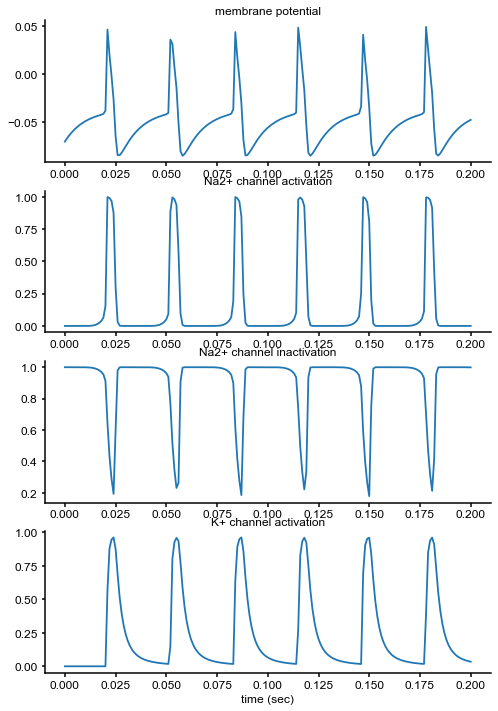

In [2]:
u0 = torch.tensor([-70e-03, 0, 1, 0])
tspan = torch.tensor([0., 0.2])
p = torch.tensor(*[params])

u, t = de(u0, tspan, p)


plt.figure(figsize=(8,12))
plt.subplot(4,1,1)
plt.plot(t, u[0,:])
plt.title('membrane potential')
plt.subplot(4,1,2)
plt.plot(t, u[1,:])
plt.title('Na2+ channel activation')
plt.subplot(4,1,3)
plt.plot(t, u[2,:])
plt.title('Na2+ channel inactivation')
plt.subplot(4,1,4)
plt.plot(t, u[3,:])
plt.title('K+ channel activation')
plt.xlabel('time (sec)');

In [3]:
%timeit u, t = de(u0, tspan, p)

3.45 ms ± 218 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
